In [ ]:
!pip install tqdm
!pip install kaggle
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import zipfile
from google.colab import drive
import os
drive.mount('/content/drive')
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!cat ~/.kaggle/kaggle.json
from kaggle.api.kaggle_api_extended import KaggleApi


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
{"username":"swimzebra","key":"b5feb024964305a9f5de76a1cba38d4b"}

In [ ]:
import os
!kaggle datasets download -d swimzebra/tl-ml-cell-images -p /content/dataset/

tl-ml-cell-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
zip_file_path = '/content/dataset/tl-ml-cell-images.zip'
extract_dir = '/content/dataset/extracted_dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
#reading the labels
data = pd.read_csv('/content/dataset/extracted_dataset/label.csv')
label_data = np.array(data['label']) - 1

In [ ]:
##Resizing, normalizing images and creating a images_array
import matplotlib.image as mpimg
from skimage import io, transform
from skimage import exposure
N = len(label_data) #total number of images in the dataset
new_size = (80, 80)  # Specify the new size (width, height)
shape_image_data = (N, new_size[0], new_size[1], 1)
resized_images = np.empty(shape_image_data)

iterate_array = range(1,N+1)

for i, image_ind in tqdm(enumerate(iterate_array)):
    image_path = f'/content/dataset/extracted_dataset/cells/cells/{image_ind}.png'
    raw_image_0 = io.imread(image_path)

    raw_image = np.array(raw_image_0).astype(float)
    resized_image = transform.resize(raw_image, new_size)

    normalized_image =  exposure.rescale_intensity(resized_image, in_range='image', out_range=(0, 1))

    resized_images[i,:,:,0] = normalized_image

<ipython-input-9-391c4d7b741b>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, image_ind in tqdm(enumerate(iterate_array)):


0it [00:00, ?it/s]

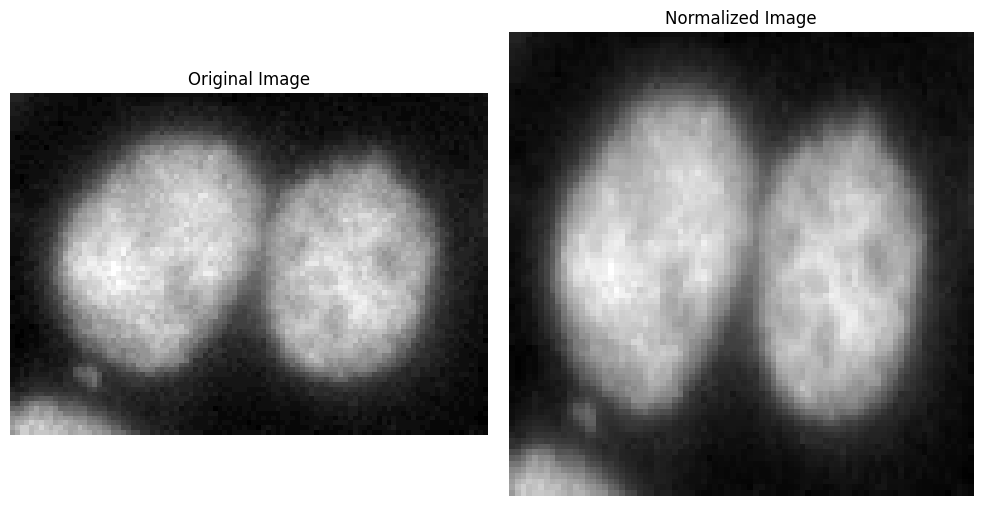

In [ ]:
from PIL import Image
from skimage import exposure
import matplotlib.pyplot as plt
import random

# plot a random image from the dataset
random_number = random.randint(0, len(label_data)-1)
image = Image.open(f'/content/dataset/extracted_dataset/cells/cells/{random_number+1}.png')
image_array = np.array(image)

# Normalize the image
normalized_image = resized_images[random_number,:,:,0]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
axes[0].imshow(image_array, cmap='gray')
axes[0].set_title('Original Image')

# Plot the normalized image
axes[1].imshow(normalized_image, cmap='gray')
axes[1].set_title('Normalized Image')

# Remove the axis labels
for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()




In [ ]:
import tensorflow as tf
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.utils import to_categorical
#2-layer CNN

In [ ]:
def batch_split(selected_types, resized_images, label_data, percentage,  encoding):
    from sklearn.preprocessing import OneHotEncoder

   #select only images in selected_types for training/testing
    training_indices = []
    for image_type in selected_types:
        indices = np.where(label_data == image_type)[0] #obtain the images of type image_type
        selected_indices = np.random.choice(indices, int(percentage*len(indices)/100)) #select n_per_type randomly chosen images
        training_indices = np.append(training_indices, selected_indices)
    training_indices = np.array(training_indices).astype(int)
    x_train = resized_images[training_indices,:,:,:] #one-hot encode target column


    testing_indices = [i for i in range(len(label_data)) \
                    if i not in training_indices and label_data[i] in selected_types]
    x_test = resized_images[testing_indices, :, :, :]

    if encoding:
        y_train = to_categorical(label_data[training_indices], num_classes = 6)
        y_test = to_categorical(label_data[testing_indices], num_classes = 6)
    else:
        y_train = label_data[training_indices]
        y_test = label_data[testing_indices]

    return x_train, y_train, x_test, y_test

In [ ]:
percentage = 70 #no. of images of each type
selected_types = list(range(6))
encoding = 'true'
x_train, y_train, x_test, y_test = batch_split(selected_types, resized_images, label_data, percentage, encoding)

#create model
model = Sequential()    #add model layers
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(80,80,1), batch_size=64))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'],run_eagerly=True)

In [ ]:
print(selected_types)
x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

x_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)
history = model.fit(x_train_tensor, y_train_tensor, validation_data=(x_test_tensor, y_test_tensor), epochs=3)

[0, 1, 2, 3, 4, 5]
Epoch 1/3


1388/1388 [==============================] - 64s 38ms/step - loss: 0.6289 - accuracy: 0.7583 - val_loss: 0.5996 - val_accuracy: 0.7786
Epoch 2/3
1388/1388 [==============================] - 56s 40ms/step - loss: 0.3903 - accuracy: 0.8559 - val_loss: 0.5413 - val_accuracy: 0.8105
Epoch 3/3
1388/1388 [==============================] - 48s 35ms/step - loss: 0.2508 - accuracy: 0.9098 - val_loss: 0.5569 - val_accuracy: 0.8137


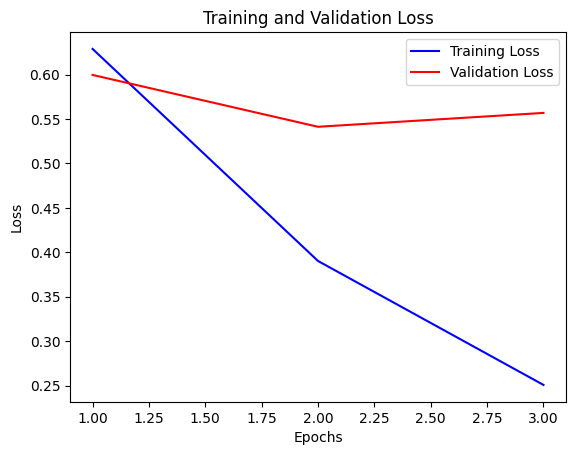

In [ ]:
# Access the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 0)

plt.show()

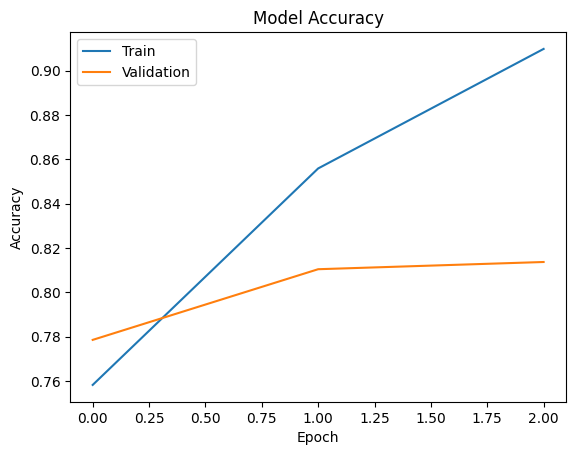

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc = 0)
plt.show()

In [ ]:
#Calculate F1 score
from sklearn.metrics import f1_score

# True labels and predicted labels
true_labels = y_test
predicted_labels = model.predict(x_test)

# Calculate the F1 score
f1 = f1_score(true_labels, predicted_labels)

print(f"F1 score: {f1}")

